In [982]:
# Load the relevant libraries
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import ee
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

In [962]:
# Open the time series datasets for the Dynamic Ocean Simulation and Prescribed SST Simulation
ref_dynamic = Dataset('tsi.ref50abrupt1500yrev.nc')
ref_prescribed = Dataset('tsi.ref50osst1500y.nc')

In [963]:
# Extract the relevant variables from the datasets, focusing on the first 500 years of the simulations  
# Time in years
time = ref_dynamic.variables['time'][:500]
# Surface Air Temperature
airtemp_dynamic = ref_dynamic.variables['A_sat'][:500]
airtemp_prescribed = ref_prescribed.variables['A_sat'][:500]
# Sea Surface Temperature
sst_dynamic = ref_dynamic.variables['O_tempsur'][:500]
sst_prescribed = ref_prescribed.variables['O_tempsur'][:500]
# NPP
npp_dynamic = ref_dynamic.variables['L_vegnpp'][:500]
npp_prescribed = ref_prescribed.variables['L_vegnpp'][:500]
# Create another variable called sim_year which will be the simulation year, going from 1 to 500
sim_year = np.linspace(1,500, num = 500)

In [964]:
# Build the dataframe using panda, and add all the previously extracted variables 
df = pd.DataFrame({
    'time': time,
    'sim_year': sim_year,
    'airtemp_dynamic': temp_dynamic,
    'airtemp_prescribed': temp_prescribed,
    'sst_dynamic': sst_dynamic,
    'sst_prescribed': sst_prescribed,
    'npp_dynamic': npp_dynamic,
    'npp_prescribed': npp_prescribed    
})
# Given that year starts somewhat arbitrarily at year 3850 in the simulations, add another column where the year would start in 1525 and end in 2024 to be able to match the end of the simulation with historical data 
df['year'] = df['time']-2325.5
# Display the first 5 rows of the DataFrame to check its accuracy
df.head()

,time,sim_year,airtemp_dynamic,airtemp_prescribed,sst_dynamic,sst_prescribed,npp_dynamic,npp_prescribed,year
0,3850.500,1.000,12.667,12.669,17.490,17.491,79.288,79.287,1525.000
1,3851.500,2.000,12.668,12.669,17.490,17.491,79.284,79.283,1526.000
2,3852.500,3.000,12.669,12.669,17.490,17.491,79.264,79.261,1527.000
3,3853.500,4.000,12.668,12.669,17.491,17.491,79.238,79.238,1528.000
4,3854.500,5.000,12.667,12.669,17.490,17.491,79.214,79.209,1529.000


In [965]:
# Convert the 'year' column to numeric values
df['year'] = pd.to_numeric(df['year'])

# Apply a lambda function to each value in the 'year' column, converting it to a datetime object
# It constructs a date using January 1st of each year (e.g., "YYYY-01-01")
# The 'errors=coerce' ensures that data before year 1677 returns NaT, but all other years are converted to a panda datetime object
df['year'] = df['year'].apply(lambda x: pd.to_datetime(f"{int(x)}-01-01", errors='coerce'))

# Set the 'year' column as the new index for the DataFrame, making it a DatetimeIndex
df.index = df['year']

# Drop the original 'year' and 'time' columns from the DataFrame as they are no longer needed
df = df.drop(columns=['year', 'time'])

# Display the last 5 rows of the DataFrame to verify the changes
df.tail()

,sim_year,airtemp_dynamic,airtemp_prescribed,sst_dynamic,sst_prescribed,npp_dynamic,npp_prescribed
year,,,,,,,
2020-01-01,496.000,12.976,12.707,17.685,17.491,68.471,67.225
2021-01-01,497.000,12.978,12.706,17.686,17.491,68.478,67.229
2022-01-01,498.000,12.978,12.706,17.686,17.491,68.495,67.254
2023-01-01,499.000,12.978,12.706,17.686,17.491,68.483,67.250
2024-01-01,500.000,12.979,12.706,17.687,17.491,68.484,67.247


In [970]:
# Trigger the Earth Engine authentication flow
ee.Authenticate()

# Initialize the Earth Engine library
ee.Initialize(project='ee-pbanville99')

# Load the MODIS NPP (Net Primary Productivity) ImageCollection for analysis
modis_npp = ee.ImageCollection('MODIS/006/MOD17A3HGF')

# Define the scaling factor for NPP data from the MODIS collection
# MODIS NPP values are scaled by 0.0001 to represent kg C/m^2/year, and then scaled by 0.1 to get g C/m^2/year
scaling_factor = 0.1

# Define a function to calculate the global mean NPP for a given year
def calculate_modis_npp(year):
    # Define the start and end dates for the specific year
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    
    # Filter the MODIS NPP ImageCollection to get data for that specific year
    # This Modis Collection only has one value per band per year at each pixel
    annual_npp = modis_npp.filterDate(start_date, end_date).first()
    
    # Select and annual NPP value and apply the scaling factor to convert the NPP data to g C/m^2/year
    annual_npp_scaled = annual_npp.select('Npp').multiply(scaling_factor)
    
    # Reduce the scaled NPP data globally to calculate the mean global NPP for that year
    global_mean_npp = annual_npp_scaled.reduceRegion(
        reducer=ee.Reducer.mean(),   # Use a mean reducer to compute the average
        geometry=ee.Geometry.Polygon([[-180, -90], [-180, 90], [180, 90], [180, -90]]),  # Global extent (entire Earth)
        scale=5000,  # The resolution scale for the reduction (MODIS NPP has a 5 km resolution)
        maxPixels=1e13  # A limit to the number of pixels to include in the calculation
    )
    
    # Return the year and the calculated mean global NPP as a feature
    return ee.Feature(None, {
        'year': year,
        'global_mean_npp': global_mean_npp
    })

# Generate an Earth Engine years list representing the years 2000 through 2021 (last historical year)
years = ee.List.sequence(2000, 2021)

# Calculate the global mean NPP for each year in the years list and stores the results in a FeatureCollection
npp_time_series = ee.FeatureCollection(years.map(lambda year: calculate_modis_npp(ee.Number(year))))

# Retrieve the result as a list and print the time series of global mean NPP for each year
npp_time_series_list = npp_time_series.getInfo()

In [971]:
# Extract the list of features (each feature contains NPP data for a specific year)
features = npp_time_series_list['features']

# Create a list of dictionaries, where each dictionary holds the year and the global mean NPP value
data_list = [{
    'year': pd.to_datetime(feature['properties']['year'], format='%Y'),  # Convert year to datetime format
    'global_mean_npp': feature['properties']['global_mean_npp']['Npp']   # Extract the global mean NPP value
} for feature in features]

# Create a pandas DataFrame from the list of dictionaries
npp_historical = pd.DataFrame(data_list)

# Set the 'year' column as the index of the DataFrame
npp_historical.set_index('year', inplace=True)

# Display the DataFrame
npp_historical

,global_mean_npp
year,
2000-01-01,503.032
2001-01-01,492.449
2002-01-01,478.936
2003-01-01,513.707
2004-01-01,523.108
2005-01-01,511.567
2006-01-01,527.113
2007-01-01,516.160
2008-01-01,517.530


In [974]:
# Merge the 'df' DataFrame with 'npp_historical' DataFrame on the 'year' column (left join, retaining all rows from the 'df' dataframe).
# This adds the 'global_mean_npp' data from 'npp_historical' to 'df', matching on the 'year' column.

df_merged = pd.merge(df, npp_historical, left_on='year', right_on='year', how = 'left')

# Convert 'global_mean_npp' from g C/m^2/year to Pg C/year (petagrams of carbon per year) to be in the same units as the simulations
# - Multiply by 148,429,000 (the approximate land area in km^2) to scale the global NPP to total land area.
# - Multiply by 1,000,000 to convert from km2 to m2
# - Divide by 10^15 to convert g to Pg (petagrams).
df_merged['npp_historical'] = df_merged['global_mean_npp'] * 1000 * 1000 * 148429000 / (10**15)

# Drop the 'global_mean_npp' column since it's no longer needed.
df_merged = df_merged.drop(columns=['global_mean_npp'])

# Display the last 20 rows of the merged DataFrame to check the results.
df_merged.tail(20)

,sim_year,airtemp_dynamic,airtemp_prescribed,sst_dynamic,sst_prescribed,npp_dynamic,npp_prescribed,npp_historical
year,,,,,,,,
2005-01-01,481.000,12.970,12.706,17.681,17.491,68.460,67.258,75.931
2006-01-01,482.000,12.970,12.706,17.681,17.491,68.468,67.256,78.239
2007-01-01,483.000,12.969,12.706,17.681,17.491,68.453,67.246,76.613
2008-01-01,484.000,12.971,12.706,17.682,17.491,68.455,67.241,76.817
2009-01-01,485.000,12.971,12.706,17.681,17.491,68.459,67.228,78.313
2010-01-01,486.000,12.972,12.706,17.682,17.491,68.482,67.249,78.851
2011-01-01,487.000,12.971,12.706,17.682,17.491,68.467,67.247,80.319
2012-01-01,488.000,12.972,12.706,17.682,17.491,68.478,67.258,77.520
2013-01-01,489.000,12.973,12.706,17.683,17.491,68.465,67.247,78.979


In [975]:
# Create a data summary table using the group by approach

# Define the bins that represent intervals of simulation years
bins = [0, 100, 200, 300, 400, 500]

# Label the groups corresponding to each bin range
labels = ['1-100', '101-200', '201-300', '301-400', '401-500'] 

# Create a new column 'sim_years' that categorizes 'sim_year' into the defined bins
df['sim_years'] = pd.cut(df['sim_year'], bins=bins, labels=labels, right=False)

# Group the DataFrame by 'sim_years' and calculate the mean of relevant columns 
# surface air temperature for dynamic and prescribed simulations, and sea surface temperature for dynamic and prescribed simulation
grouped_df = df.groupby('sim_years')[['airtemp_dynamic', 'airtemp_prescribed', 'sst_dynamic', 'sst_prescribed']].mean()

# Rename the columns to make them more descriptive
grouped_df = grouped_df.rename(columns={
    'airtemp_dynamic': 'Mean SAT Dynamic Ocean Simulation',  # SAT: Surface Air Temperature
    'airtemp_prescribed': 'Mean SAT Prescribed SST Simulation',
    'sst_dynamic': 'Mean SST Dynamic Ocean Simulation',      # SST: Sea Surface Temperature
    'sst_prescribed': 'Mean SST Prescribed SST Simulation'
})

# Rename the index (axis) to make it more descriptive
grouped_df = grouped_df.rename_axis('Simulation Years')

# Set display format for pandas to show floats with three decimal points globally for cleaner presentation
pd.options.display.float_format = '{:.3f}'.format

# Output the final grouped DataFrame with mean values
grouped_df

,Mean SAT Dynamic Ocean Simulation,Mean SAT Prescribed SST Simulation,Mean SST Dynamic Ocean Simulation,Mean SST Prescribed SST Simulation
Simulation Years,,,,
1-100,12.671,12.675,17.488,17.491
101-200,12.729,12.687,17.522,17.491
201-300,12.848,12.701,17.599,17.491
301-400,12.914,12.702,17.643,17.491
401-500,12.956,12.704,17.672,17.491


<function matplotlib.pyplot.show(close=None, block=None)>

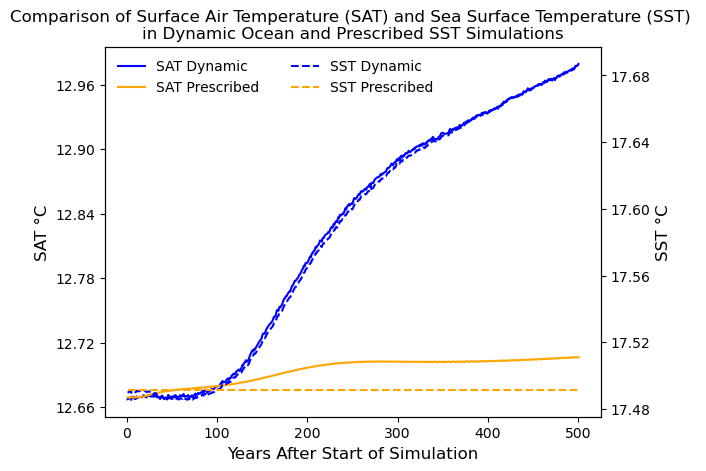

In [995]:
# Create a time-series plot comparing surface air temperature and sea surface temperature for both simulations

# Create a figure and a set of subplots (ax1 will be the primary axis)
fig, ax1 = plt.subplots()

# Plot the surface air temperature (SAT) for the dynamic ocean simulation on the primary axis (ax1)
ax1.plot(df['sim_year'], df['airtemp_dynamic'], label='SAT Dynamic', color='blue', linestyle='-')

# Plot the surface air temperature (SAT) for the prescribed SST simulation on the same primary axis (ax1)
ax1.plot(df['sim_year'], df['airtemp_prescribed'], label='SAT Prescribed', color='orange', linestyle='-')

# Add a legend to the primary axis (ax1) to distinguish between the SAT dynamic and prescribed simulations
plt.legend(frameon=False, facecolor='none')

# Create a secondary y-axis (ax2) that shares the same x-axis as ax1
ax2 = ax1.twinx()

# Plot the sea surface temperature (SST) for the dynamic ocean simulation on the secondary axis (ax2)
ax2.plot(df['sim_year'], df['sst_dynamic'], label='SST Dynamic', color='blue', linestyle='--')

# Plot the sea surface temperature (SST) for the prescribed SST simulation on the secondary axis (ax2)
ax2.plot(df['sim_year'], df['sst_prescribed'], label='SST Prescribed', color='orange', linestyle='--')

# Set the number of major ticks on the y-axis of ax1 to 6 (for SAT)
ax1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

# Set the number of major ticks on the y-axis of ax2 to 6 (for SST)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

# Format the major ticks on the y-axis of ax1 to display with two decimal points
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Format the major ticks on the y-axis of ax2 to display with two decimal points
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Set the x-axis label for ax1 (which also applies to ax2 since they share the x-axis)
ax1.set_xlabel('Years After Start of Simulation', fontsize=12)

# Set the y-axis label for ax1 to indicate it's showing SAT in degrees Celsius
ax1.set_ylabel('SAT °C', fontsize = 12)

# Set the y-axis label for ax2 to indicate it's showing SST in degrees Celsius
ax2.set_ylabel('SST °C', fontsize = 12)

# Add a title to the plot
plt.title('Comparison of Surface Air Temperature (SAT) and Sea Surface Temperature (SST) \nin Dynamic Ocean and Prescribed SST Simulations')

# Add another legend for the secondary axis (ax2) and adjust its position so it doesn't overlap and lines up well with the other legend
plt.legend(frameon=False, facecolor='none', loc='upper left', bbox_to_anchor=(0.35, 1))

# Save the figure
file_path = 'C:/Users/peban/ComparisonSATSST.png'  # Specify the path and file name
plt.savefig(file_path, format='png', bbox_inches='tight')# Save the figure

plt.show

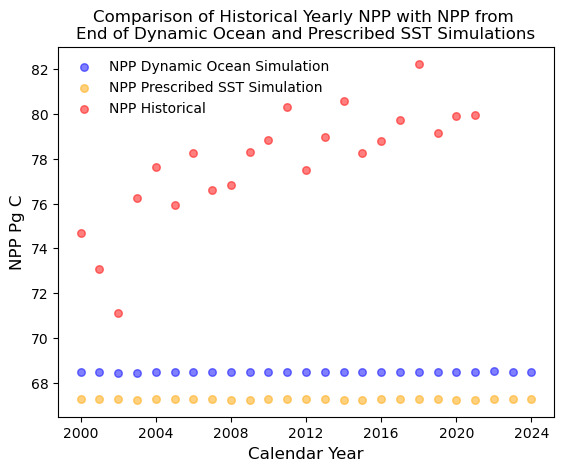

In [981]:
# Create a scatter plot comparing NPP from both simulations to historical NPP

# Create scatter plot for NPP Dynamic Ocean Simulation
plt.scatter(
    df_merged.index[475:500],  # X-axis: Calendar years (index)
    df_merged['npp_dynamic'][475:500],  # Y-axis: NPP values from the dynamic simulation
    label='NPP Dynamic Ocean Simulation',  # Label for the legend
    color='blue',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Create scatter plot for NPP Prescribed SST Simulation
plt.scatter(
    df_merged.index[475:500],  # X-axis: Calendar years (index)
    df_merged['npp_prescribed'][475:500],  # Y-axis: NPP values from the prescribed SST simulation
    label='NPP Prescribed SST Simulation',  # Label for the legend
    color='orange',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Create scatter plot for NPP Historical data
plt.scatter(
    df_merged.index[475:500],  # X-axis: Calendar years (index)
    df_merged['npp_historical'][475:500],  # Y-axis: NPP values from historical data
    label='NPP Historical',  # Label for the legend
    color='red',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Add a legend in the upper left corner without a frame
plt.legend(loc='upper left', frameon=False, facecolor='none')

# Set the title of the plot
plt.title('Comparison of Historical Yearly NPP with NPP from \nEnd of Dynamic Ocean and Prescribed SST Simulations')

# Label the x-axis
plt.xlabel("Calendar Year", fontsize=12)

# Label the y-axis
plt.ylabel('NPP Pg C', fontsize=12);

C:\Users\peban\AppData\Local\Temp\ipykernel_17956\2318297793.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_inset.set_yticklabels([f'{tick:.2f}' for tick in y_ticks], fontsize=8)  # Format Y-tick labels to 2 decimals
C:\Users\peban\AppData\Local\Temp\ipykernel_17956\2318297793.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_inset2.set_yticklabels([f'{tick:.2f}' for tick in y_ticks], fontsize=8)  # Format Y-tick labels to 2 decimals


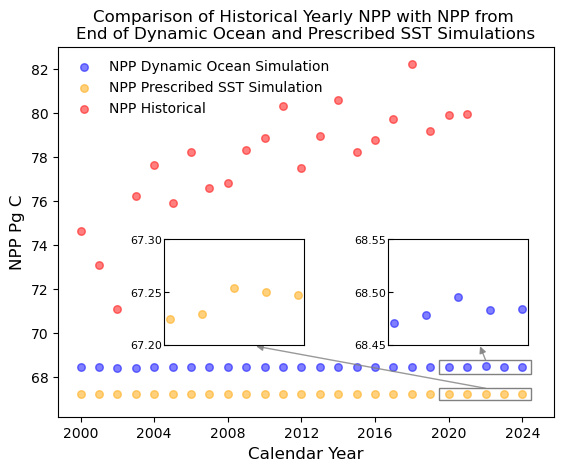

In [994]:
# Create a scatter plot comparing NPP from both simulations to historical NPP

# Create scatter plot for NPP Dynamic Ocean Simulation
plt.scatter(
    df_merged.index[475:500],  # X-axis: Calendar years (index)
    df_merged['npp_dynamic'][475:500],  # Y-axis: NPP values from the dynamic simulation
    label='NPP Dynamic Ocean Simulation',  # Label for the legend
    color='blue',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Create scatter plot for NPP Prescribed SST Simulation
plt.scatter(
    df_merged.index[475:500],  # X-axis: Calendar years (index)
    df_merged['npp_prescribed'][475:500],  # Y-axis: NPP values from the prescribed SST simulation
    label='NPP Prescribed SST Simulation',  # Label for the legend
    color='orange',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Create scatter plot for NPP Historical data
plt.scatter(
    df_merged.index[475:500],  # X-axis: Calendar years (index)
    df_merged['npp_historical'][475:500],  # Y-axis: NPP values from historical data
    label='NPP Historical',  # Label for the legend
    color='red',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Add a legend in the upper left corner without a frame
plt.legend(loc='upper left', frameon=False, facecolor='none')

# Set the title of the plot
plt.title('Comparison of Historical Yearly NPP with NPP from \nEnd of Dynamic Ocean and Prescribed SST Simulations')

# Label the x-axis
plt.xlabel("Calendar Year", fontsize = 12)

# Label the y-axis
plt.ylabel('NPP Pg C', fontsize = 12)

# Get the current axes for adding rectangles
ax = plt.gca()

# Calculate the position and dimensions for the rectangle covering NPP Prescribed SST simulation data
rect_x_start = df_merged.index[494] + (df_merged.index[495] - df_merged.index[494]) / 2  # Start X position
rect_width = df_merged.index[499] - df_merged.index[494]  # Width of the rectangle covering 5 years
rect_y_start = df_merged['npp_prescribed'][495:500].min() - 0.25  # Start Y position (lowest value in the last 5 years - buffer)
rect_height = df_merged['npp_prescribed'][495:500].max() + 0.25 - rect_y_start  # Height of the rectangle (highest value in last 5 years - starting position + buffer)

# Create the rectangle for NPP Prescribed SST simulation data
rect = patches.Rectangle(
    (rect_x_start, rect_y_start),  # Position (X, Y)
    rect_width,  # Width
    rect_height,  # Height
    linewidth=1,  # Line width
    edgecolor='gray',  # Color of the rectangle edge
    facecolor='none',  # No fill color
    linestyle='-'  # Solid line style
)
# Add the rectangle to the current axes
ax.add_patch(rect)

# Calculate the position and dimensions for the rectangle covering NPP Dynamic Ocean Simulation data
rect_x_start2 = df_merged.index[494] + (df_merged.index[495] - df_merged.index[494]) / 2  # Start X position
rect_width2 = df_merged.index[499] - df_merged.index[494]  # Width of the rectangle covering 5 years
rect_y_start2 = df_merged['npp_dynamic'][495:500].min() - 0.3  # Start Y position (lowest value in the last 5 years - buffer)
rect_height2 = df_merged['npp_dynamic'][495:500].max() + 0.3 - rect_y_start2  # Height of the rectangle (highest value in last 5 years - starting position + buffer)

# Create the rectangle for NPP Dynamic Ocean Simulation data
rect2 = patches.Rectangle(
    (rect_x_start2, rect_y_start2),  # Position (X, Y)
    rect_width2,  # Width
    rect_height2,  # Height
    linewidth=1,  # Line width
    edgecolor='gray',  # Color of the rectangle edge
    facecolor='none',  # No fill color
    linestyle='-'  # Solid line style
)
# Add the rectangle to the current axes
ax.add_patch(rect2)

# Create an inset axes for the NPP Dynamic Simulation data
ax_inset = inset_axes(
    plt.gca(),  # Parent axes
    width="20%",  # Width of the inset
    height="20%",  # Height of the inset
    loc='center',  # Location of the inset
    bbox_to_anchor=(0.20, -0.18, 1.1, 1.1),  # Position of the inset
    bbox_transform=plt.gcf().transFigure  # Transform coordinates to figure coordinates
)

# Scatter plot for the last 5 years of NPP Dynamic data in the inset
last_5_years_indices = df_merged.index[495:500]  # Indices for the last 5 years
ax_inset.scatter(
    last_5_years_indices,  # X-axis: Calendar years (index)
    df_merged['npp_dynamic'][495:500],  # Y-axis: NPP values from the dynamic simulation
    color='blue',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Set Y-axis limits and ticks for the inset
ax_inset.set_ylim(68.45, 68.55)  # Y-axis limits
y_ticks = [68.45, 68.5, 68.55]  # Y-tick values

# Remove X-axis labels from the inset
ax_inset.set_xticklabels([])  # Remove X-tick labels
ax_inset.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide X-axis ticks
# Set custom Y-tick labels for the inset
ax_inset.set_yticklabels([f'{tick:.2f}' for tick in y_ticks], fontsize=8)  # Format Y-tick labels to 2 decimals
ax_inset.tick_params(axis='y', direction='in', pad=1)  # Adjust Y-axis tick parameters

# Create another inset axes for the NPP Prescribed SST Simulation data
ax_inset2 = inset_axes(
    plt.gca(),  # Parent axes
    width="20%",  # Width of the inset
    height="20%",  # Height of the inset
    loc='center',  # Location of the inset
    bbox_to_anchor=(-0.15, -0.18, 1.1, 1.1),  # Position of the inset relative to center
    bbox_transform=plt.gcf().transFigure  # Transform coordinates to figure coordinates
)

# Scatter plot for the last 5 years of NPP Prescribed data in the inset
last_5_years_indices = df_merged.index[495:500]  # Indices for the last 5 years
ax_inset2.scatter(
    last_5_years_indices,  # X-axis: Calendar years (index)
    df_merged['npp_prescribed'][495:500],  # Y-axis: NPP values from the prescribed SST simulation
    color='orange',  # Color of the points
    s=30,  # Size of the points
    alpha=0.5  # Transparency level of the points
)

# Set Y-axis limits and ticks for the inset
ax_inset2.set_ylim(67.2, 67.3)  # Y-axis limits
y_ticks = [67.2, 67.25, 67.3]  # Y-tick values

# Remove X-axis labels from the inset
ax_inset2.set_xticklabels([])  # Remove X-tick labels
ax_inset2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide X-axis ticks
# Set custom Y-tick labels for the inset
ax_inset2.set_yticklabels([f'{tick:.2f}' for tick in y_ticks], fontsize=8)  # Format Y-tick labels to 2 decimals
ax_inset2.tick_params(axis='y', direction='in', pad=1)  # Adjust Y-axis tick parameters

# Create a connection patch between the middle of the rectangle for Dynamic Ocean Simulation data and the middle of the corresponding inset graph
con1 = ConnectionPatch(
    # Define the coordinates for the starting point (middle of the top edge of the Dynamic Ocean Simulation rectangle)
    xyA=(rect_x_start_dynamic + rect_width_dynamic / 2, rect_y_start_dynamic + rect_height_dynamic), 
    # Define the coordinates for the ending point (middle of inset for Prescribed SST Simulation data)
    xyB=(df_merged.index[497], 68.45), 
    # Use 'data' coordinates for both axes (the actual data values in the plots)
    coordsA="data", 
    coordsB="data", 
    # Specify the axes for the starting and ending points
    axesA=ax, 
    axesB=ax_inset_dynamic, 
    # Set the color of the connection line to gray
    color="gray", 
    # Set the transparency of the connection line to 0.8 (80% opaque)
    alpha=0.8, 
    # Define the style of the arrow at the end of the connection line
    arrowstyle='-|>'
)
# Add the connection patch to the main axes (ax)
ax.add_patch(con1)

# Create a connection patch between the middle of the rectangle for Prescribed SST Simulation data and the middle of the corresponding inset graph
con2 = ConnectionPatch(
    # Define the coordinates for the starting point (middle of the top edge of the prescribed rectangle)
    xyA=(rect_x_start_prescribed + rect_width_prescribed / 2, 
         rect_y_start_prescribed + rect_height_prescribed),
    # Define the coordinates for the ending point (middle of inset for Prescribed SST Simulation data)
    xyB=(df_merged.index[497], 67.2), 
    # Specify that both coordinates are in 'data' coordinate system
    coordsA="data", 
    coordsB="data", 
    # Specify the axes for the starting and ending points
    axesA=ax, 
    axesB=ax_inset_prescribed, 
    # Set the color of the connection line or arrow to gray
    color="gray", 
    # Set the arrow style for the connection
    arrowstyle='-|>', 
    # Set the transparency of the connection line or arrow
    alpha=0.8
)
# Add the connection patch to the main axes (ax)
ax.add_patch(con2)

# Save the figure
file_path = 'C:/Users/peban/NPPScatter.png'  # Specify the path and file name
plt.savefig(file_path, format='png', bbox_inches='tight')  # Save the figure

# Display the plot
plt.show()

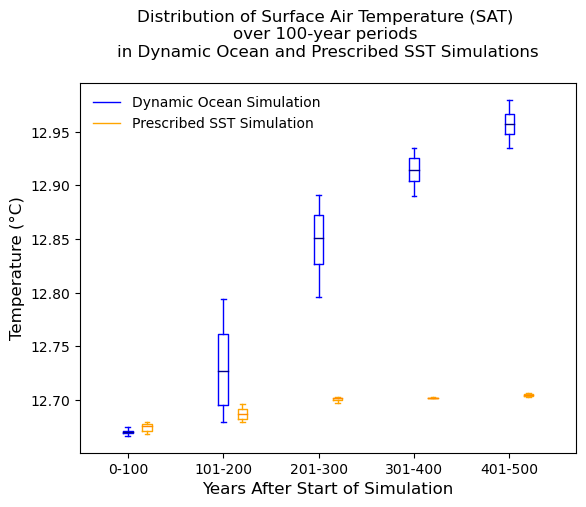

In [988]:
# Prepare a boxplot showing the distribution of surface air temperature per 100 years of simulation for both simulations

# Data to be plotted
# Extract the first 100 surface air temperature values for dynamic ocean and prescribed sst simulations
dynamic_data1 = df_merged['airtemp_dynamic'][0:100]
prescribed_data1 = df_merged['airtemp_prescribed'][0:100]
# Extract the next 100 surface air temperature values for the next set of dynamic and prescribed simulations
dynamic_data2 = df_merged['airtemp_dynamic'][100:200]
prescribed_data2 = df_merged['airtemp_prescribed'][100:200]
# Continue extracting data for additional sets of 100
dynamic_data3 = df_merged['airtemp_dynamic'][200:300]
prescribed_data3 = df_merged['airtemp_prescribed'][200:300]
dynamic_data4 = df_merged['airtemp_dynamic'][300:400]
prescribed_data4 = df_merged['airtemp_prescribed'][300:400]
dynamic_data5 = df_merged['airtemp_dynamic'][400:500]
prescribed_data5 = df_merged['airtemp_prescribed'][400:500]

# Main plot for the boxplots
# Create boxplots for the dynamic ocean simulation temperature data
plt.boxplot(dynamic_data1, 
            positions=[1],  # Position on the x-axis for this boxplot
            widths=0.1,  # Width of the box
            showfliers=False,  # Do not show outliers as individual points
            boxprops=dict(color='blue'),  # Color properties of the box
            whiskerprops=dict(color='blue'),  # Color properties of the whiskers
            capprops=dict(color='blue'),  # Color properties of the caps (the horizontal lines at the ends of the whiskers)
            medianprops=dict(color='darkblue'))  # Color of the median line inside the box

# Repeat the process for the remaining dynamic temperature datasets
plt.boxplot(dynamic_data2, positions=[2], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))
plt.boxplot(dynamic_data3, positions=[3], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))
plt.boxplot(dynamic_data4, positions=[4], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))
plt.boxplot(dynamic_data5, positions=[5], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))

# Create boxplots for the prescribed air temperature data
plt.boxplot(prescribed_data1, 
            positions=[1.2],  # Slightly offset position on the x-axis
            widths=0.1,  # Width of the box
            boxprops=dict(color='orange'),  # Box color for prescribed data
            whiskerprops=dict(color='orange'),  # Whisker color
            capprops=dict(color='orange'),  # Cap color
            medianprops=dict(color='darkorange'))  # Median line color

# Repeat for the remaining prescribed datasets with appropriate offsets
plt.boxplot(prescribed_data2, positions=[2.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))
plt.boxplot(prescribed_data3, positions=[3.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))
plt.boxplot(prescribed_data4, positions=[4.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))
plt.boxplot(prescribed_data5, positions=[5.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))

# Set the x-tick labels for the boxplots to represent the ranges of years
plt.xticks([1, 2, 3, 4, 5], ['0-100', '101-200', '201-300', '301-400', '401-500'], fontsize=10)
# Label the y-axis for temperature, indicating the unit and font size
plt.ylabel('Temperature (°C)', fontsize=12)
# Label the x-axis for years after the start of the simulation, indicating the font size
plt.xlabel('Years After Start of Simulation', fontsize=12)
# Set the title for the plot with specified position (y=1.05 for vertical position) and font size
plt.title('Distribution of Surface Air Temperature (SAT) \nover 100-year periods \nin Dynamic Ocean and Prescribed SST Simulations', y=1.05, fontsize=12)

# Adding the legend for the boxplots to distinguish between simulations
legend_elements = [
    Line2D([0], [0], color='blue', lw=1, label='Dynamic Ocean Simulation'),  # Create a legend entry for dynamic ocean simulation
    Line2D([0], [0], color='orange', lw=1, label='Prescribed SST Simulation')  # Create a legend entry for prescribed sst simulation
]
# Display the legend in the upper left corner without a frame
plt.legend(handles=legend_elements, loc='upper left', frameon=False, facecolor='none')


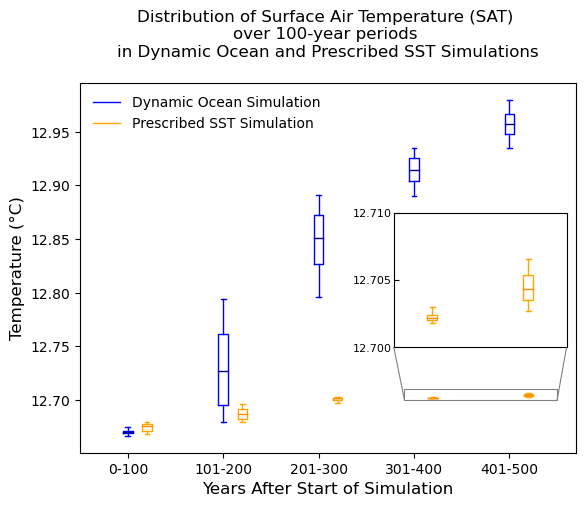

In [992]:
# Prepare a boxplot showing the distribution of surface air temperature per 100 years of simulation for both simulations

# Data to be plotted
# Extract the first 100 surface air temperature values for dynamic ocean and prescribed sst simulations
dynamic_data1 = df_merged['airtemp_dynamic'][0:100]
prescribed_data1 = df_merged['airtemp_prescribed'][0:100]
# Extract the next 100 surface air temperature values for the next set of dynamic and prescribed simulations
dynamic_data2 = df_merged['airtemp_dynamic'][100:200]
prescribed_data2 = df_merged['airtemp_prescribed'][100:200]
# Continue extracting data for additional sets of 100
dynamic_data3 = df_merged['airtemp_dynamic'][200:300]
prescribed_data3 = df_merged['airtemp_prescribed'][200:300]
dynamic_data4 = df_merged['airtemp_dynamic'][300:400]
prescribed_data4 = df_merged['airtemp_prescribed'][300:400]
dynamic_data5 = df_merged['airtemp_dynamic'][400:500]
prescribed_data5 = df_merged['airtemp_prescribed'][400:500]

# Main plot for the boxplots
# Create boxplots for the dynamic ocean simulation temperature data
plt.boxplot(dynamic_data1, 
            positions=[1],  # Position on the x-axis for this boxplot
            widths=0.1,  # Width of the box
            showfliers=False,  # Do not show outliers as individual points
            boxprops=dict(color='blue'),  # Color properties of the box
            whiskerprops=dict(color='blue'),  # Color properties of the whiskers
            capprops=dict(color='blue'),  # Color properties of the caps (the horizontal lines at the ends of the whiskers)
            medianprops=dict(color='darkblue'))  # Color of the median line inside the box

# Repeat the process for the remaining dynamic temperature datasets
plt.boxplot(dynamic_data2, positions=[2], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))
plt.boxplot(dynamic_data3, positions=[3], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))
plt.boxplot(dynamic_data4, positions=[4], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))
plt.boxplot(dynamic_data5, positions=[5], widths=0.1, 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='blue'), 
            capprops=dict(color='blue'), 
            medianprops=dict(color='darkblue'))

# Create boxplots for the prescribed air temperature data
plt.boxplot(prescribed_data1, 
            positions=[1.2],  # Slightly offset position on the x-axis
            widths=0.1,  # Width of the box
            boxprops=dict(color='orange'),  # Box color for prescribed data
            whiskerprops=dict(color='orange'),  # Whisker color
            capprops=dict(color='orange'),  # Cap color
            medianprops=dict(color='darkorange'))  # Median line color

# Repeat for the remaining prescribed datasets with appropriate offsets
plt.boxplot(prescribed_data2, positions=[2.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))
plt.boxplot(prescribed_data3, positions=[3.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))
plt.boxplot(prescribed_data4, positions=[4.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))
plt.boxplot(prescribed_data5, positions=[5.2], widths=0.1, 
            boxprops=dict(color='orange'), 
            whiskerprops=dict(color='orange'), 
            capprops=dict(color='orange'), 
            medianprops=dict(color='darkorange'))

# Set the x-tick labels for the boxplots to represent the ranges of years
plt.xticks([1, 2, 3, 4, 5], ['0-100', '101-200', '201-300', '301-400', '401-500'], fontsize=10)
# Label the y-axis for temperature, indicating the unit and font size
plt.ylabel('Temperature (°C)', fontsize=12)
# Label the x-axis for years after the start of the simulation, indicating the font size
plt.xlabel('Years After Start of Simulation', fontsize=12)
# Set the title for the plot with specified position (y=1.05 for vertical position) and font size
plt.title('Distribution of Surface Air Temperature (SAT) \nover 100-year periods \nin Dynamic Ocean and Prescribed SST Simulations', y=1.05, fontsize=12)

# Adding the legend for the boxplots to distinguish between simulations
legend_elements = [
    Line2D([0], [0], color='blue', lw=1, label='Dynamic Ocean Simulation'),  # Create a legend entry for dynamic ocean simulation
    Line2D([0], [0], color='orange', lw=1, label='Prescribed SST Simulation')  # Create a legend entry for prescribed sst simulation
]
# Display the legend in the upper left corner without a frame
plt.legend(handles=legend_elements, loc='upper left', frameon=False, facecolor='none')

# Get the current axes to add rectangles and inset in relation to current axes
ax = plt.gca()

# Add a rectangle around prescribed_data4 and prescribed_data5 since they are displayed in the inset
rect = Rectangle((3.9, 12.70), 1.6, 0.01, linewidth=0.8, edgecolor='gray', facecolor='none')
# Add the rectangle to the current axes 
ax.add_patch(rect)

# Create an inset axes for zooming into prescribed_data4 and prescribed_data5
ax_inset = inset_axes(plt.gca(), 
                      width="30%",  # Width of the inset axes as a fraction of the parent axes
                      height="20%",  # Height of the inset axes as a fraction of the parent axes
                      loc='center',  # Location of the inset axes
                      bbox_to_anchor=(0.3, -0.23, 0.9, 1.4),  # Positioning of the inset axes in the figure
                      bbox_transform=plt.gcf().transFigure)  # Use the figure's coordinate system for positioning
# Create a boxplot in the inset for prescribed data from the specified ranges
ax_inset.boxplot([prescribed_data4, prescribed_data5], 
                 widths=0.05,  # Width of the box in the inset
                 positions=[1, 1.5],  # Positions on the x-axis for the inset boxplots
                 boxprops=dict(color='orange'),  # Box color for the inset
                 whiskerprops=dict(color='orange'),  # Whisker color for the inset
                 capprops=dict(color='orange'),  # Cap color for the inset
                 medianprops=dict(color='darkorange'))  # Median line color for the inset

# Set the y-axis limits for the inset to zoom in on a specific data range
ax_inset.set_ylim(12.70, 12.71)
# Set the x-axis limits for the inset to focus on the relevant data range
ax_inset.set_xlim(0.8, 1.7)

# Define y-ticks for the inset
y_ticks = [12.700, 12.705, 12.710]  
# Set the y-axis ticks for the inset to control the displayed ticks
ax_inset.set_yticks(y_ticks)  
# Format the y-tick labels to three decimal places for clarity
ax_inset.set_yticklabels([f'{tick:.3f}' for tick in y_ticks], fontsize=8)
# Disable x-tick labels for the inset to avoid clutter
ax_inset.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Set y-tick parameters for the inset for a cleaner look
ax_inset.tick_params(axis='y', direction='in', pad=1)

# Link rectangle to the inset using ConnectionPatch 
# Create aConnectionPatch linking the rectangle to the lower right corner of the inset
con1 = ConnectionPatch(xyA=(5.5, 12.70),  # Coordinates in the main plot for the connection
                       xyB=(1, 0),  # Coordinates in the inset plot for the connection
                       coordsA="data",  # Use data coordinates for the main plot
                       coordsB="axes fraction",  # Use axes fraction for the inset plot
                       axesA=ax,  # Reference to the main axes
                       axesB=ax_inset,  # Reference to the inset axes
                       color="gray",  # Color of the connection line
                       lw=0.8)  # Line width of the connection
# Create another ConnectionPatch linking the rectangle to the lower left corner of the inset
con2 = ConnectionPatch(xyA=(3.9, 12.70), 
                       xyB=(0, 0), 
                       coordsA="data", 
                       coordsB="axes fraction", 
                       axesA=ax, 
                       axesB=ax_inset, 
                       color="gray", 
                       lw=0.8)
# Add both connection patches to the current figure
plt.gcf().add_artist(con1)
plt.gcf().add_artist(con2)

# Save the figure
file_path = 'C:/Users/peban/SATdistribution.png'  # Specify the path and file name
plt.savefig(file_path, format='png', bbox_inches='tight')  # Save the figure

# Show the complete plot
plt.show()

